In [57]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, boxcox, pearsonr

# from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, HuberRegressor

import lightgbm as lgb
import xgboost as xgb

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from Dataset import RegionalDatasets

from ModelOptimizer import (
    lgbm_optimizer, 
    xgb_optimizer, 
    rf_optimizer, 
    svr_optimizer, 
    ridge_optimizer, 
    huber_optimizer,
    model_box
)

from MetaModel import RegionalBasedPredictors

In [2]:
def metric_train(output, truth):
    return spearmanr(output, truth).correlation

def my_metric(output, data):
    return "spearman", spearmanr(output, data.get_label()).correlation, True

In [3]:
X_train = pd.read_csv("X_train_NHkHMNU.csv").set_index("ID")
y_train = pd.read_csv("y_train_ZAN5mwg.csv").set_index("ID")
X_test = pd.read_csv("X_test_final.csv").set_index("ID")
X_train.shape, y_train.shape, X_test.shape

((1494, 34), (1494, 1), (654, 34))

In [4]:
X_train.describe().loc[["mean", "std"]].T

,mean,std
DAY_ID,591.861446,345.065043
DE_CONSUMPTION,0.427442,0.673412
FR_CONSUMPTION,-0.020032,0.918995
DE_FR_EXCHANGE,-0.145508,0.970226
FR_DE_EXCHANGE,0.145508,0.970226
DE_NET_EXPORT,-0.256332,0.957443
FR_NET_EXPORT,-0.072643,1.075830
DE_NET_IMPORT,0.256332,0.957443
FR_NET_IMPORT,0.072643,1.075830
DE_GAS,0.780699,0.850190


In [5]:
X_test.describe().loc[["mean", "std"]].T

,mean,std
DAY_ID,632.744648,356.751037
DE_CONSUMPTION,0.435242,0.802119
FR_CONSUMPTION,0.034431,0.985306
DE_FR_EXCHANGE,-0.044960,0.900125
FR_DE_EXCHANGE,0.044960,0.900125
DE_NET_EXPORT,-0.221057,0.943074
FR_NET_EXPORT,-0.124737,1.005925
DE_NET_IMPORT,0.221057,0.943074
FR_NET_IMPORT,0.124737,1.005925
DE_GAS,0.822771,0.880446


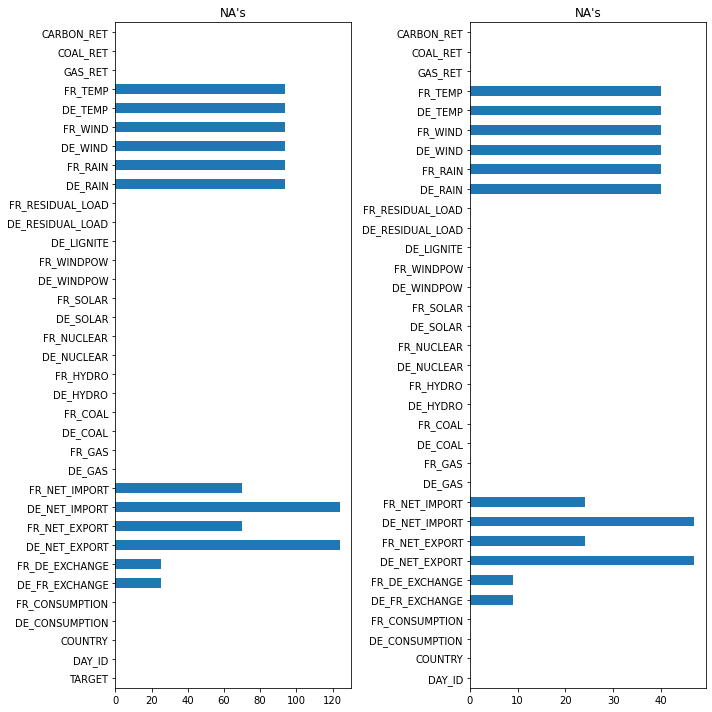

In [6]:
full_train = y_train.join(X_train)
full_train = full_train.replace("FR", 0)
full_train = full_train.replace("DE", 1)

X_test = X_test.replace("FR", 0)
X_test = X_test.replace("DE", 1)

fig, axs = plt.subplots(1,2,figsize=(10,10))
full_train.isna().sum(axis=0).plot(kind="barh", title="NA's", ax=axs[0])
X_test.isna().sum(axis=0).plot(kind="barh", title="NA's", ax=axs[1])
plt.tight_layout()

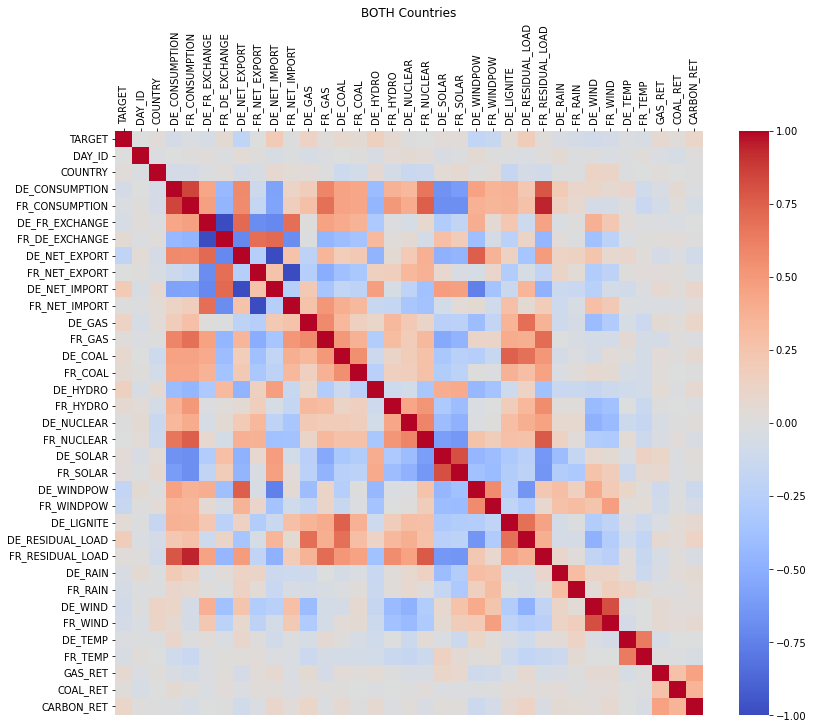

In [7]:
corr_train = full_train.corr(method="spearman")
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr_train, cmap='coolwarm')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("BOTH Countries")
plt.show()

In [8]:
weather = ["FR_TEMP", "DE_TEMP", "FR_WIND", "DE_WIND", "FR_RAIN", "DE_RAIN"]
full_train[weather] = full_train[weather].fillna(full_train[weather].mean())
X_test[weather] = X_test[weather].fillna(full_train[weather].mean())

related_cols = corr_train.columns.to_list()[4:-5]
imputer = KNNImputer(n_neighbors=5)
imputer.fit(full_train[related_cols])
full_train[related_cols] = imputer.transform(full_train[related_cols])
X_test[related_cols] = imputer.transform(X_test[related_cols])

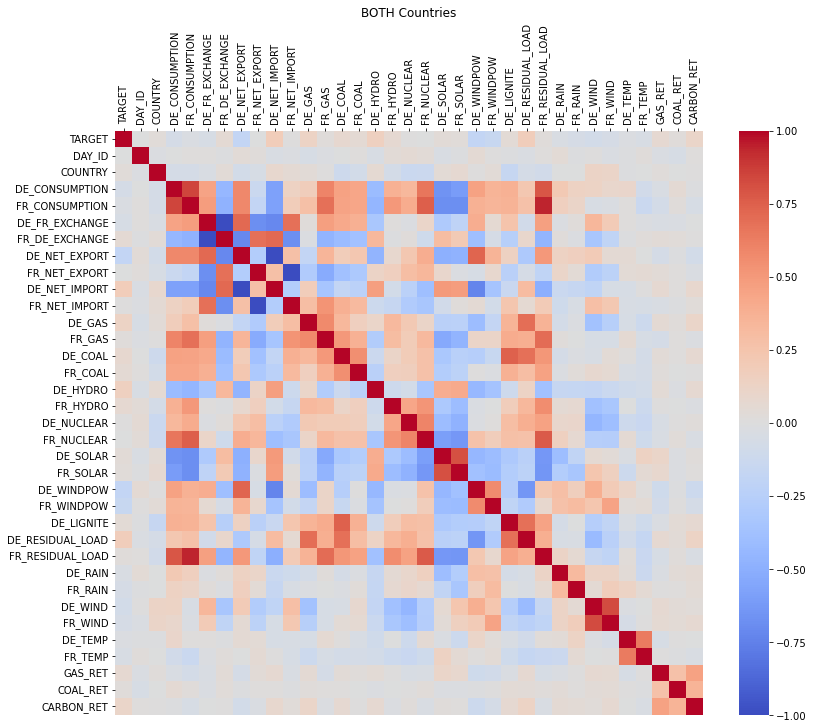

In [9]:
corr_train = full_train.corr(method="spearman")
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr_train, cmap='coolwarm')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("BOTH Countries")
plt.show()

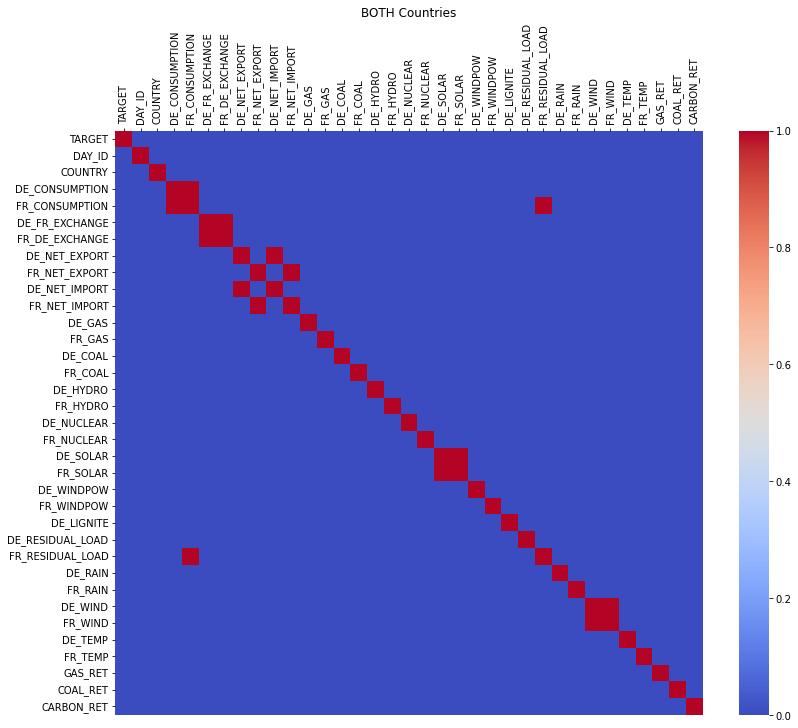

In [10]:
plt.figure(figsize=(12,10))
thres = 0.8
ax = sns.heatmap(corr_train.abs() > thres, cmap='coolwarm')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("BOTH Countries")
plt.show()

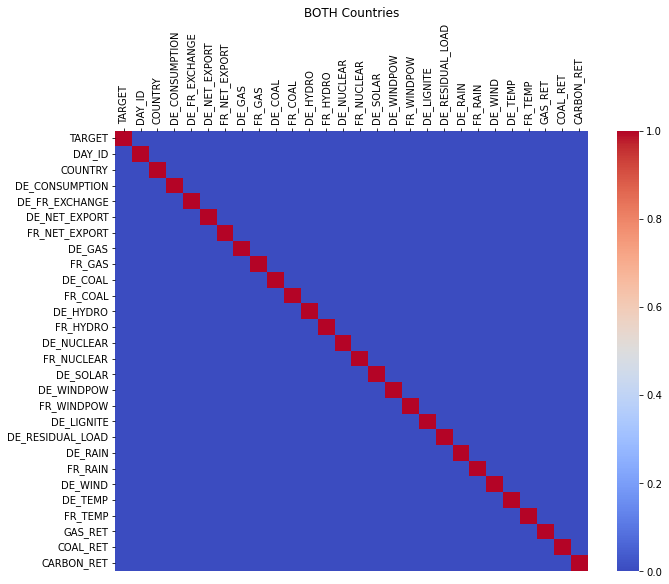

In [11]:
multi_collin_cols = ["FR_RESIDUAL_LOAD", "FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT"]
multi_collin_cols += ["FR_CONSUMPTION", "FR_SOLAR", "FR_WIND"] # 0.8
# multi_collin_cols += ["DE_NET_EXPORT", "DE_LIGNITE"] # 0.7
fe1_train = full_train.drop(multi_collin_cols, axis=1)

plt.figure(figsize=(10,8))
ax = sns.heatmap(fe1_train.corr(method="spearman").abs() > thres, cmap='coolwarm')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("BOTH Countries")
plt.show()

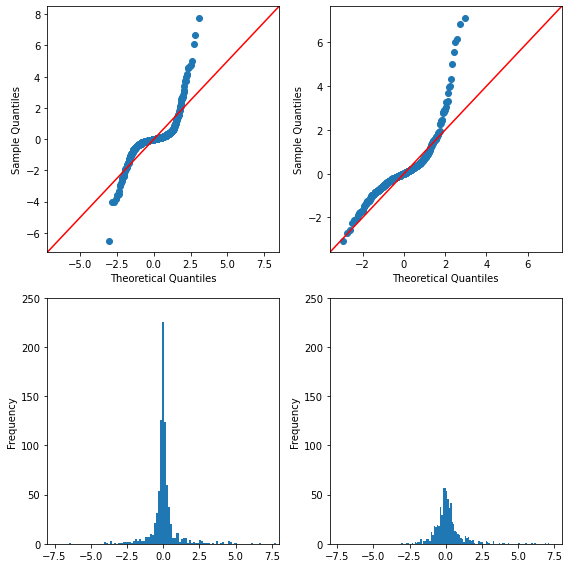

In [12]:
fr_target = full_train.loc[full_train.COUNTRY==0,"TARGET"]
de_target = full_train.loc[full_train.COUNTRY==1,"TARGET"]

fig, axs = plt.subplots(2,2,figsize=(8,8))
sm.qqplot(fr_target, line='45', ax=axs[0][0])
sm.qqplot(de_target, line='45', ax=axs[0][1])

fr_target.plot.hist(bins=100, ax=axs[1][0])
axs[1][0].set_xlim(-8, 8)
axs[1][0].set_ylim(0, 250)
de_target.plot.hist(bins=100, ax=axs[1][1])
axs[1][1].set_xlim(-8, 8)
axs[1][1].set_ylim(0, 250)

plt.tight_layout()
plt.show()


In [13]:
fe1_train = fe1_train.sort_values("DAY_ID")
fe1_train['RANK'] = fe1_train.TARGET.rank()

drop_X_dict = {
    'fr': ["TARGET", "DAY_ID", "RANK", "COUNTRY"],
    'de': ["TARGET", "DAY_ID", "RANK", "COUNTRY"],
    'both': ["TARGET", "DAY_ID", "RANK"]
}
ds = RegionalDatasets(fe1_train, exclude_X_cols_by_region=drop_X_dict, y_col='RANK')
ds_X_y_dict = ds.to_dict()

In [14]:
drop_X_dict_test = {
    'fr': multi_collin_cols+['DAY_ID', 'COUNTRY'],
    'de': multi_collin_cols+['DAY_ID', 'COUNTRY'],
    'both': multi_collin_cols+['DAY_ID'],
}

ds_test = RegionalDatasets(X_test, exclude_X_cols_by_region=drop_X_dict_test)
ds_test_X_y_dict = ds_test.to_dict()

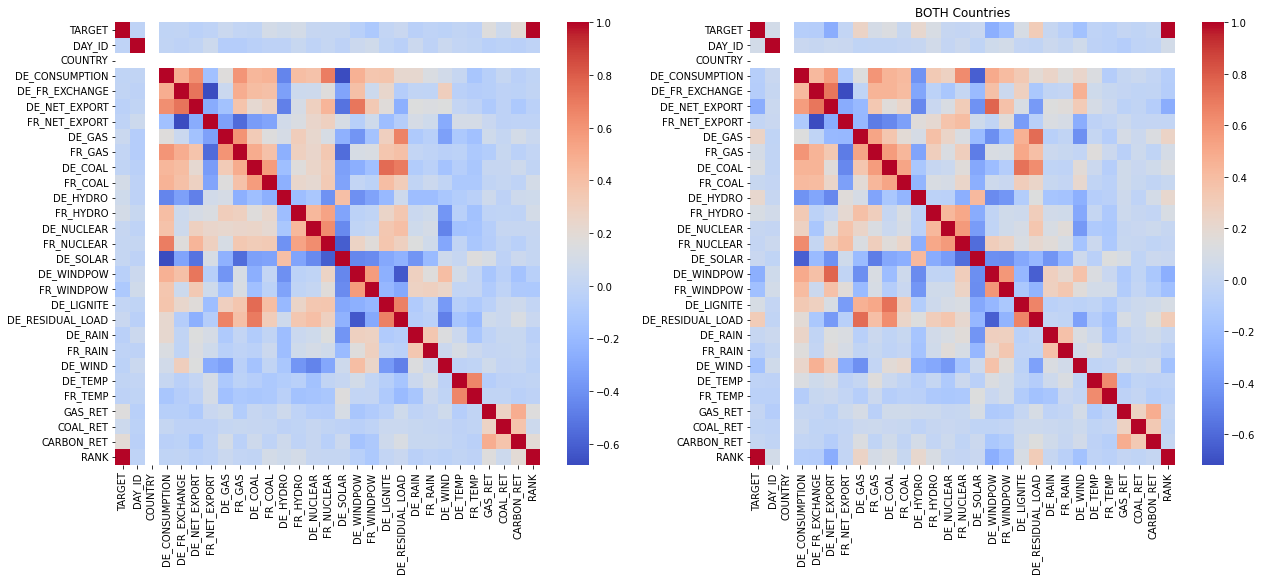

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))
ax = sns.heatmap(ds.dataset_fr.dtrain.corr(method="spearman"), cmap='coolwarm', ax=axs[0])
ax = sns.heatmap(ds.dataset_de.dtrain.corr(method="spearman"), cmap='coolwarm', ax=axs[1])
plt.tight_layout()
plt.title("BOTH Countries")
plt.show()

In [16]:
# print("LGBM")
# lgbm_fr = lgbm_optimizer(ds_X_y_dict['train']['fr']['X'], ds_X_y_dict['valid']['fr']['X'], ds_X_y_dict['train']['fr']['y'], ds_X_y_dict['valid']['fr']['y'])
# lgbm_fr.run()
# lgbm_de = lgbm_optimizer(ds_X_y_dict['train']['de']['X'], ds_X_y_dict['valid']['de']['X'], ds_X_y_dict['train']['de']['y'], ds_X_y_dict['valid']['de']['y'])
# lgbm_de.run()
# lgbm_full = lgbm_optimizer(ds_X_y_dict['train']['both']['X'], ds_X_y_dict['valid']['both']['X'], ds_X_y_dict['train']['both']['y'], ds_X_y_dict['valid']['both']['y'])
# lgbm_full.run()

# lgbm_fr.dump_best_model("voting_models/lgbm_fr.json")
# lgbm_de.dump_best_model("voting_models/lgbm_de.json")
# lgbm_full.dump_best_model("voting_models/lgbm_both.json")

# print("XGB")
# xgb_fr = xgb_optimizer(ds_X_y_dict['train']['fr']['X'], ds_X_y_dict['valid']['fr']['X'], ds_X_y_dict['train']['fr']['y'], ds_X_y_dict['valid']['fr']['y'])
# xgb_fr.run()
# xgb_de = xgb_optimizer(ds_X_y_dict['train']['de']['X'], ds_X_y_dict['valid']['de']['X'], ds_X_y_dict['train']['de']['y'], ds_X_y_dict['valid']['de']['y'])
# xgb_de.run()
# xgb_full = xgb_optimizer(ds_X_y_dict['train']['both']['X'], ds_X_y_dict['valid']['both']['X'], ds_X_y_dict['train']['both']['y'], ds_X_y_dict['valid']['both']['y'])
# xgb_full.run()

# xgb_fr.dump_best_model("voting_models/xgb_fr.json")
# xgb_de.dump_best_model("voting_models/xgb_de.json")
# xgb_full.dump_best_model("voting_models/xgb_both.json")

# print("RandomForest")
# rf_fr = rf_optimizer(ds_X_y_dict['train']['fr']['X'], ds_X_y_dict['valid']['fr']['X'], ds_X_y_dict['train']['fr']['y'], ds_X_y_dict['valid']['fr']['y'])
# rf_fr.run()
# rf_de = rf_optimizer(ds_X_y_dict['train']['de']['X'], ds_X_y_dict['valid']['de']['X'], ds_X_y_dict['train']['de']['y'], ds_X_y_dict['valid']['de']['y'])
# rf_de.run()
# rf_full = rf_optimizer(ds_X_y_dict['train']['both']['X'], ds_X_y_dict['valid']['both']['X'], ds_X_y_dict['train']['both']['y'], ds_X_y_dict['valid']['both']['y'])
# rf_full.run()

# rf_fr.dump_best_model("voting_models/rf_fr.json")
# rf_de.dump_best_model("voting_models/rf_de.json")
# rf_full.dump_best_model("voting_models/rf_both.json")

# print("SVR")
# svr_fr = svr_optimizer(ds_X_y_dict['train']['fr']['X'], ds_X_y_dict['valid']['fr']['X'], ds_X_y_dict['train']['fr']['y'], ds_X_y_dict['valid']['fr']['y'])
# svr_fr.run()
# svr_de = svr_optimizer(ds_X_y_dict['train']['de']['X'], ds_X_y_dict['valid']['de']['X'], ds_X_y_dict['train']['de']['y'], ds_X_y_dict['valid']['de']['y'])
# svr_de.run()
# svr_full = svr_optimizer(ds_X_y_dict['train']['both']['X'], ds_X_y_dict['valid']['both']['X'], ds_X_y_dict['train']['both']['y'], ds_X_y_dict['valid']['both']['y'])
# svr_full.run()

# svr_fr.dump_best_model("voting_models/svr_fr.json")
# svr_de.dump_best_model("voting_models/svr_de.json")
# svr_full.dump_best_model("voting_models/svr_both.json")

# print("Ridge")
# ridge_fr = ridge_optimizer(ds_X_y_dict['train']['fr']['X'], ds_X_y_dict['valid']['fr']['X'], ds_X_y_dict['train']['fr']['y'], ds_X_y_dict['valid']['fr']['y'])
# ridge_fr.run()
# ridge_de = ridge_optimizer(ds_X_y_dict['train']['de']['X'], ds_X_y_dict['valid']['de']['X'], ds_X_y_dict['train']['de']['y'], ds_X_y_dict['valid']['de']['y'])
# ridge_de.run()
# ridge_full = ridge_optimizer(ds_X_y_dict['train']['both']['X'], ds_X_y_dict['valid']['both']['X'], ds_X_y_dict['train']['both']['y'], ds_X_y_dict['valid']['both']['y'])
# ridge_full.run()

# ridge_fr.dump_best_model("voting_models/ridge_fr.json")
# ridge_de.dump_best_model("voting_models/ridge_de.json")
# ridge_full.dump_best_model("voting_models/ridge_both.json")

# print("Huber")
# huber_fr = huber_optimizer(ds_X_y_dict['train']['fr']['X'], ds_X_y_dict['valid']['fr']['X'], ds_X_y_dict['train']['fr']['y'], ds_X_y_dict['valid']['fr']['y'])
# huber_fr.run()
# huber_de = huber_optimizer(ds_X_y_dict['train']['de']['X'], ds_X_y_dict['valid']['de']['X'], ds_X_y_dict['train']['de']['y'], ds_X_y_dict['valid']['de']['y'])
# huber_de.run()
# huber_full = huber_optimizer(ds_X_y_dict['train']['both']['X'], ds_X_y_dict['valid']['both']['X'], ds_X_y_dict['train']['both']['y'], ds_X_y_dict['valid']['both']['y'])
# huber_full.run()

# huber_fr.dump_best_model("voting_models/huber_fr.json")
# huber_de.dump_best_model("voting_models/huber_de.json")
# huber_full.dump_best_model("voting_models/huber_both.json")

[I 2023-06-24 10:01:02,044] A new study created in memory with name: no-name-8d1a3863-db5b-4a22-b52f-bcb9ef6799ef


LGBM
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

In [37]:
mbox = model_box('voting_models')
model_candidates, model_scores = mbox.to_dicts()

In [38]:
train_X_dict = {k: d['X'] for k, d in ds_X_y_dict['train'].items()}
val_X_dict = {k: d['X'] for k, d in ds_X_y_dict['valid'].items()}
full_X_dict = {k: d['X'] for k, d in ds_X_y_dict['full'].items()}
test_X_dict = {k: d['X'] for k, d in ds_test_X_y_dict['full'].items()}

In [39]:
bpreds_tra, bpreds_val = [], []
score_tra, score_val = [], []
for key in model_candidates.keys():
    rbp = RegionalBasedPredictors(key, model_candidates[key], ds_X_y_dict['train'], val_X_dict)
    val_pred = rbp.aggregate_predictions()
    score_val.append(metric_train(val_pred[f'{key}_both_pred'], ds_X_y_dict['valid']['both']['y']))
    score_val.append(metric_train(val_pred[f'{key}_regional_pred'], ds_X_y_dict['valid']['both']['y']))
    bpreds_val.append(val_pred)
    
    rbp.prediction_X = train_X_dict
    tra_pred = rbp.aggregate_predictions()
    score_tra.append(metric_train(tra_pred[f'{key}_both_pred'], ds_X_y_dict['train']['both']['y']))
    score_tra.append(metric_train(tra_pred[f'{key}_regional_pred'], ds_X_y_dict['train']['both']['y']))
    bpreds_tra.append(tra_pred)

bpreds_val = pd.concat(bpreds_val, axis=1)
bpreds_tra = pd.concat(bpreds_tra, axis=1)

In [40]:
# weights = np.ones(12)
# weights = 1 / np.array(score_tra)
weights = np.array(score_val)

train_pred = bpreds_tra.apply(lambda x: x @ weights / np.sum(weights), axis=1)
print(metric_train(train_pred, ds_X_y_dict['train']['both']['y']))

val_pred = bpreds_val.apply(lambda x: x @ weights / np.sum(weights), axis=1)
print(metric_train(val_pred, ds_X_y_dict['valid']['both']['y']))

0.571466146337305
0.3311651814774079


In [41]:
bpreds_full, bpreds_test = [], []
for key in model_candidates.keys():
    rbp = RegionalBasedPredictors(key, model_candidates[key], ds_X_y_dict['full'], test_X_dict)
    bpreds_test.append(rbp.aggregate_predictions())

    rbp.prediction_X = full_X_dict
    bpreds_full.append(rbp.aggregate_predictions())

bpreds_test = pd.concat(bpreds_test, axis=1)
bpreds_full = pd.concat(bpreds_full, axis=1)

In [42]:
# Best # sub14
submission = bpreds_test.apply(lambda x: x @ weights / np.sum(weights), axis=1).rename('TARGET')
# submission.to_csv('sub15.csv')
submission

ID
1115    0.163259
1202    0.867624
1194   -1.425772
1084    1.056190
1135   -0.367906
          ...   
879    -2.291587
673    -0.317378
1641    1.482014
712     1.504704
1060    0.805955
Name: TARGET, Length: 654, dtype: float64

In [63]:
print(1 - metric_train(pd.read_csv('sub11.csv')['TARGET'], submission))
print(1 - pearsonr(pd.read_csv('sub11.csv')['TARGET'], submission)[0])

0.06624654782234618
0.05638899276274367


# Blending Try

In [80]:
ds_meta = RegionalDatasets(fe1_train, 0.2, 0.2, drop_X_dict, 'RANK')
ds_meta_X_y_dict = ds_meta.to_dict()

In [81]:
# print("LGBM")
# lgbm_fr = lgbm_optimizer(ds_meta_X_y_dict['train']['fr']['X'], ds_meta_X_y_dict['valid']['fr']['X'], ds_meta_X_y_dict['train']['fr']['y'], ds_meta_X_y_dict['valid']['fr']['y'])
# lgbm_fr.run()
# lgbm_de = lgbm_optimizer(ds_meta_X_y_dict['train']['de']['X'], ds_meta_X_y_dict['valid']['de']['X'], ds_meta_X_y_dict['train']['de']['y'], ds_meta_X_y_dict['valid']['de']['y'])
# lgbm_de.run()
# lgbm_full = lgbm_optimizer(ds_meta_X_y_dict['train']['both']['X'], ds_meta_X_y_dict['valid']['both']['X'], ds_meta_X_y_dict['train']['both']['y'], ds_meta_X_y_dict['valid']['both']['y'])
# lgbm_full.run()

# lgbm_fr.dump_best_model("base_models/lgbm_fr.json")
# lgbm_de.dump_best_model("base_models/lgbm_de.json")
# lgbm_full.dump_best_model("base_models/lgbm_both.json")

# print("XGB")
# xgb_fr = xgb_optimizer(ds_meta_X_y_dict['train']['fr']['X'], ds_meta_X_y_dict['valid']['fr']['X'], ds_meta_X_y_dict['train']['fr']['y'], ds_meta_X_y_dict['valid']['fr']['y'])
# xgb_fr.run()
# xgb_de = xgb_optimizer(ds_meta_X_y_dict['train']['de']['X'], ds_meta_X_y_dict['valid']['de']['X'], ds_meta_X_y_dict['train']['de']['y'], ds_meta_X_y_dict['valid']['de']['y'])
# xgb_de.run()
# xgb_full = xgb_optimizer(ds_meta_X_y_dict['train']['both']['X'], ds_meta_X_y_dict['valid']['both']['X'], ds_meta_X_y_dict['train']['both']['y'], ds_meta_X_y_dict['valid']['both']['y'])
# xgb_full.run()

# xgb_fr.dump_best_model("base_models/xgb_fr.json")
# xgb_de.dump_best_model("base_models/xgb_de.json")
# xgb_full.dump_best_model("base_models/xgb_both.json")

# print("RandomForest")
# rf_fr = rf_optimizer(ds_meta_X_y_dict['train']['fr']['X'], ds_meta_X_y_dict['valid']['fr']['X'], ds_meta_X_y_dict['train']['fr']['y'], ds_meta_X_y_dict['valid']['fr']['y'])
# rf_fr.run()
# rf_de = rf_optimizer(ds_meta_X_y_dict['train']['de']['X'], ds_meta_X_y_dict['valid']['de']['X'], ds_meta_X_y_dict['train']['de']['y'], ds_meta_X_y_dict['valid']['de']['y'])
# rf_de.run()
# rf_full = rf_optimizer(ds_meta_X_y_dict['train']['both']['X'], ds_meta_X_y_dict['valid']['both']['X'], ds_meta_X_y_dict['train']['both']['y'], ds_meta_X_y_dict['valid']['both']['y'])
# rf_full.run()

# rf_fr.dump_best_model("base_models/rf_fr.json")
# rf_de.dump_best_model("base_models/rf_de.json")
# rf_full.dump_best_model("base_models/rf_both.json")

# print("SVR")
# svr_fr = svr_optimizer(ds_meta_X_y_dict['train']['fr']['X'], ds_meta_X_y_dict['valid']['fr']['X'], ds_meta_X_y_dict['train']['fr']['y'], ds_meta_X_y_dict['valid']['fr']['y'])
# svr_fr.run()
# svr_de = svr_optimizer(ds_meta_X_y_dict['train']['de']['X'], ds_meta_X_y_dict['valid']['de']['X'], ds_meta_X_y_dict['train']['de']['y'], ds_meta_X_y_dict['valid']['de']['y'])
# svr_de.run()
# svr_full = svr_optimizer(ds_meta_X_y_dict['train']['both']['X'], ds_meta_X_y_dict['valid']['both']['X'], ds_meta_X_y_dict['train']['both']['y'], ds_meta_X_y_dict['valid']['both']['y'])
# svr_full.run()

# svr_fr.dump_best_model("base_models/svr_fr.json")
# svr_de.dump_best_model("base_models/svr_de.json")
# svr_full.dump_best_model("base_models/svr_both.json")

# print("Ridge")
# ridge_fr = ridge_optimizer(ds_meta_X_y_dict['train']['fr']['X'], ds_meta_X_y_dict['valid']['fr']['X'], ds_meta_X_y_dict['train']['fr']['y'], ds_meta_X_y_dict['valid']['fr']['y'])
# ridge_fr.run()
# ridge_de = ridge_optimizer(ds_meta_X_y_dict['train']['de']['X'], ds_meta_X_y_dict['valid']['de']['X'], ds_meta_X_y_dict['train']['de']['y'], ds_meta_X_y_dict['valid']['de']['y'])
# ridge_de.run()
# ridge_full = ridge_optimizer(ds_meta_X_y_dict['train']['both']['X'], ds_meta_X_y_dict['valid']['both']['X'], ds_meta_X_y_dict['train']['both']['y'], ds_meta_X_y_dict['valid']['both']['y'])
# ridge_full.run()

# ridge_fr.dump_best_model("base_models/ridge_fr.json")
# ridge_de.dump_best_model("base_models/ridge_de.json")
# ridge_full.dump_best_model("base_models/ridge_both.json")

# print("Huber")
# huber_fr = huber_optimizer(ds_meta_X_y_dict['train']['fr']['X'], ds_meta_X_y_dict['valid']['fr']['X'], ds_meta_X_y_dict['train']['fr']['y'], ds_meta_X_y_dict['valid']['fr']['y'])
# huber_fr.run()
# huber_de = huber_optimizer(ds_meta_X_y_dict['train']['de']['X'], ds_meta_X_y_dict['valid']['de']['X'], ds_meta_X_y_dict['train']['de']['y'], ds_meta_X_y_dict['valid']['de']['y'])
# huber_de.run()
# huber_full = huber_optimizer(ds_meta_X_y_dict['train']['both']['X'], ds_meta_X_y_dict['valid']['both']['X'], ds_meta_X_y_dict['train']['both']['y'], ds_meta_X_y_dict['valid']['both']['y'])
# huber_full.run()

# huber_fr.dump_best_model("base_models/huber_fr.json")
# huber_de.dump_best_model("base_models/huber_de.json")
# huber_full.dump_best_model("base_models/huber_both.json")

In [82]:
mbox_base = model_box('base_models')
model_candidates, model_scores = mbox_base.to_dicts()

In [83]:
train_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['train'].items()}
val_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['valid'].items()}
ho_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['holdout'].items()}
full_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['full'].items()}
test_X_dict = {k: d['X'] for k, d in ds_test_X_y_dict['full'].items()}

In [84]:
bpreds_tra, bpreds_val, bpreds_ho = [], [], []
for key in model_candidates.keys():
    rbp = RegionalBasedPredictors(key, model_candidates[key], ds_X_y_dict['train'], val_X_dict)
    bpreds_val.append(rbp.aggregate_predictions())

    rbp.prediction_X = ho_X_dict
    bpreds_ho.append(rbp.aggregate_predictions())

    rbp.prediction_X = train_X_dict
    bpreds_tra.append(rbp.aggregate_predictions())

bpreds_tra = pd.concat(bpreds_tra, axis=1)
bpreds_val = pd.concat(bpreds_val, axis=1)
bpreds_ho = pd.concat(bpreds_ho, axis=1)

In [85]:
print(metric_train(bpreds_tra.mean(axis=1), ds_meta_X_y_dict['train']['both']['y']))
print(metric_train(bpreds_val.mean(axis=1), ds_meta_X_y_dict['valid']['both']['y']))
print(metric_train(bpreds_ho.mean(axis=1), ds_meta_X_y_dict['holdout']['both']['y']))

0.5591500765345528
0.5265063932422266
0.29335368454131217


In [86]:
lv2 = huber_optimizer(bpreds_val, bpreds_ho, ds_meta_X_y_dict['valid']['both']['y'], ds_meta_X_y_dict['holdout']['both']['y'])
lv2.run()

Best trial among 200 trials:
  Value: 0.27793046171803104


In [87]:
print(metric_train(lv2.model.predict(bpreds_tra), ds_meta_X_y_dict['train']['both']['y']))
print(metric_train(lv2.model.predict(bpreds_val), ds_meta_X_y_dict['valid']['both']['y']))
print(metric_train(lv2.model.predict(bpreds_ho), ds_meta_X_y_dict['holdout']['both']['y']))

0.9460214670427685
0.9405431309551512
0.2229597539898094


In [88]:
bpreds_full, bpreds_test = [], []
for key in model_candidates.keys():
    rbp = RegionalBasedPredictors(key, model_candidates[key], ds_meta_X_y_dict['full'], test_X_dict)
    bpreds_test.append(rbp.aggregate_predictions())

    rbp.prediction_X = full_X_dict
    bpreds_full.append(rbp.aggregate_predictions())

bpreds_test = pd.concat(bpreds_test, axis=1)
bpreds_full = pd.concat(bpreds_full, axis=1)

lv2.model.fit(bpreds_full, ds_meta_X_y_dict['full']['both']['y'])

HuberRegressor(alpha=4.982757835334436, epsilon=35.8441022142201,
               fit_intercept=False)

In [89]:
submission2 = pd.Series(lv2.model.predict(bpreds_test), index=test_X_dict['both'].index)
submission2.name = 'TARGET'
# submission.to_csv('sub16_meta.csv')

In [90]:
print(1 - metric_train(pd.read_csv('sub11.csv')['TARGET'], submission2))
print(1 - pearsonr(pd.read_csv('sub11.csv')['TARGET'], submission2)[0])

0.1369370219623437
0.1288286895582782


In [91]:
print(1 - metric_train(submission2, submission))
print(1 - pearsonr(submission2, submission)[0])

0.08400234787225946
0.08198718537997596
